In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import networkx as nx

# Importing standard Qiskit libraries
from qiskit import IBMQ

# Loading your IBM Q account(s)
provider = IBMQ.load_account()
dev = qml.device('default.qubit', wires=5)

mpl.rcParams['figure.dpi'] = 100

# Комбинаторная оптимизация
Комбинаторная оптимизация -- это поиск "оптимального" объекта среди их ограниченного множества. Например: задача коммивояжёра, задача раскроя, задача выбора маршрута. Задача комбинаторной оптимизации является NP-полной и точно решается в общем случае только методом полного перебора, сложность которого растет экспоненциально и приводит к "комбинаторному взрыву".
### Задача о максимальной клике
Выделение из неориентированного графа полного подграфа (то есть подграфа, где каждый элемент связан с каждым) максимального размера. Пример: поиск связанной группы людей среди графа пользователей социальной сети или поиск подмножества кубитов максимальной связаности. Сложность самого эффективного классического алгоритма точного решения задачи (алгоритма Брона-Кербоша) растет как $O(3^{N/3})$.

Граф $G(V, E)$ определяется из совокупности вершин $V = \{1, N\}$ и совокупности ребер $E = \{(i, j): i, j=1,\dots,N\}$. Каждому графу можно сопоставить сопряжеженный граф $G(V, \bar{E})$ с множеством ребер $\bar{E}=\{(i, j): i, j\in V \text{ and } (i, j)\notin E\}$. Обозначим количество элементов в $E$ как $M$.

Удобно описывать граф с помощью матрицы смежности графа $A$, то есть матрицы, значение $A_{ij}$ которой равно весу ребра (1 для невзвешенного графа), если $i$ и $j$ вершины соединены (т.е. $(i,j) \in E$) и 0 в обратном случае. 

Определим вектор $x$, $x_i\in\{0, 1\}, i=1,\dots,n$. То есть элементы вектора показывают, включаем ли мы в подграф вершину с номером $i$ или нет. Для полного графа $x=\mathbb{1}^N$. С использованием вектора $x$ можно сформулировать оптимизационную задачу максимальной клики:

$$
\max \sum_{i=1}^{N} x_i\\
x_i + x_j \le 1\:\forall (i, j) \in \bar{E}\\
x_i\in\{0, 1\}, i=1,\dots,n
$$

То есть максимизируется количество вершин, включенных в подграф, причем любые две вершины из сопряженного ему подграфа соединены только попарно.

Рассмотрим простой граф из 5 вершин с хорошо видной максимальной кликой. 
Ей соответствует вектор $x_{\max}=\{0, 1, 1, 1, 1\}$ или просто битовая строка "01111".

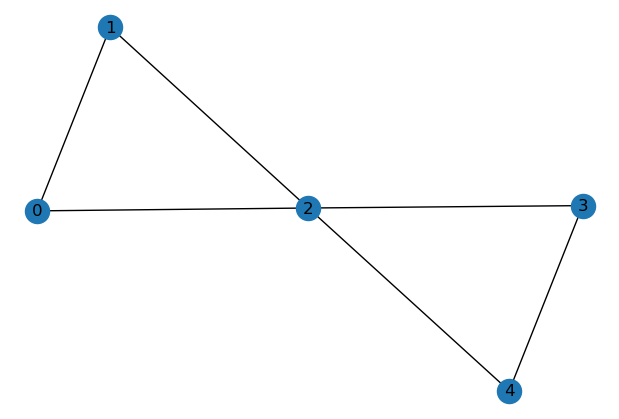

In [26]:
edges = [(0, 1), (1, 2), (2, 3), (3, 1), (3, 4), (1, 4), (2, 4)]
backend = provider.get_backend('ibmqx2')
graph = nx.Graph(backend.configuration().coupling_map)
#graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

Максимальную клику также хорошо видно по матрице смежности:

In [27]:
nx.adjacency_matrix(graph).todense()

matrix([[0, 1, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [1, 1, 0, 1, 1],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0]], dtype=int32)

# Квантовая приблизительная оптимизация (Quantum Approximate Optimization Algorithm)
QAOA -- алгоритм комбинаторной оптимизации, когда оптимальный или близкий к нему результат находится статистически. Пусть необходимо максимизировать функцию $f$ на множестве битовых строк размерности $N$. При этом битовые строки кодируются как базисные состояния, например $"01111"\to|01111\rangle$.
Можно построить $N$-кубитный гамильтониан $H_c(f)$, состояние которого с максимальной энергией соответствует максимуму целевой функции (а основное -- минимуму), то есть $\langle x|H_c|x\rangle=f(x)$.

Построим унитарный оператор эволюции для $H_c(f)$:

$$U(f, \gamma)=e^{-i\gamma H_c(f)}$$

Так как собственные значения $H_c$ целочисленные, можем ограничить $\gamma\in[0,2\pi]$. В реальных квантовых вычислениях используется приблизительная оптимизация, когда експонента суммы аппроксимируется произведением экспонент. Построим гамильтониан смешивания, необходимый для перемешивания базисных состояний и возвращения состояния в область допустимых значений. Обычно используется X-гамильтониан:

$$H_m = \sum_{j=1}^N X_j$$

и соответствующий ему унитарный оператор смешивания

$$U(H_m, \alpha)=e^{-i\alpha H_m}$$

При этом $\alpha\in[0,\pi]$.
Начальное состояние QAOA -- суперпозиция всех кубитов с равномерно распределенной вероятностью измерения $|s\rangle$.

Квантовая схема формируется послойно чередованием $U(f, \gamma)$ и $U(H_m, \alpha)$:

$$U(\vec{\gamma}, \vec{\alpha}) = \prod_{k=1}^p U(f, \gamma_k) U(H_m, \alpha_k)$$

$p$ -- количество слоев, $\vec{\gamma}, \vec{\alpha}$ -- вектора параметров слоев.
Можно подобрать параметры $\vec{\gamma}, \vec{\alpha}$ так, чтобы состояние после эволюции

$$|\vec{\gamma}, \vec{\alpha}\rangle = U(\vec{\gamma}, \vec{\alpha})|s\rangle$$

максимизировало ожидаемое значение оператора $\langle\vec{\gamma}, \vec{\alpha}| H_c(f)|\vec{\gamma}, \vec{\alpha}\rangle$. При этом одновременно ищется максимум функции $f(x)$. Истинный максимум достигается только при $p\to\infty$, но при достаточно большом $p$ можно достаточно надежно определить базисное состояние, на котором он достигается. Сложность алгоритма уже не экспоненциальная, а полиномиальная: $O(NM + M^2)$.

Построим операторы $H_c(f)$ и $H_m$ для поиска максимальной клики в введенном выше графе. Для этого в PennyLane есть встроенные средства. Так, для задачи используется Х-гамильтониан смешивания $H_m$, а целевой гамильтониан $H_c$ имеет вид комбинации Z-операторов Паули:

$$H_c = 3 \sum_{(i, j) \in E(\bar{G})}(Z_i Z_j - Z_i - Z_j) + \sum_{i \in V(G)} Z_i$$

In [28]:
cost_h, mixer_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian (0.75) [Z0 Z3]
+ (-0.5) [Z0]
+ (-0.5) [Z3]
+ (0.75) [Z0 Z4]
+ (-0.5) [Z4]
+ (0.75) [Z1 Z3]
+ (-0.5) [Z1]
+ (0.75) [Z1 Z4]
+ (1) [Z2]
Mixer Hamiltonian (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


Определим структуру слоя и построим схему с заранее заданным числом слоев.

In [43]:
depth = 3
wires = range(len(graph.degree))

def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


@qml.template
def qaoa_circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

Запустим алгоритм градиентного спуска Нестерова для поиска оптимального набора параметров.

In [21]:
def max_clique_optimize(qaoa_circuit, cost_h, depth, dev, steps):
    cost = qml.ExpvalCost(qaoa_circuit, cost_h, dev)
    opt_nesterov = qml.NesterovMomentumOptimizer(stepsize=0.01, momentum=0.9)
    nparams = [[0.1] * depth, [0.1] * depth]

    history = []
    cost_history = []

    for i in range(steps):
        # update the circuit parameters
        nparams, cost_value = opt_nesterov.step_and_cost(cost, nparams)
        history.append(nparams)
        cost_history.append(cost_value)

        if (i + 1) % 5 == 0:
            print(f"Cost after step {i + 1:4d}: {cost_value:.7f} {nparams}")

    print(f"\nOptimized rotation angles: {nparams=}")
    return nparams, history, cost_history

In [44]:
steps = 70
nparams, history, cost_history = max_clique_optimize(qaoa_circuit, cost_h, depth, dev, steps)

Cost after step    5: -0.8652911 [[-0.1705553084473972, 0.06517967709740702, 0.18094839002439084], [0.19305574560700994, 0.08721393490468726, -0.1444199065617076]]
Cost after step   10: -2.0410249 [[-0.35869586367681394, 0.10543293141432156, 0.40970502475989307], [0.45579332315847987, 0.2084558383913952, -0.33682391582230736]]
Cost after step   15: -2.5638088 [[-0.27709548531500217, -0.1005696724290284, 0.3455439739469468], [0.5071092196944788, 0.24239827084262605, -0.29633220199573806]]
Cost after step   20: -3.1481895 [[-0.40259681361908506, -0.4204378517396459, 0.4195673857057725], [0.59256831826764, 0.39643895773823123, -0.300911663633504]]
Cost after step   25: -3.2516869 [[-0.4095478767372175, -0.5663866477096151, 0.46957023815398824], [0.5696230203553344, 0.3585145309058453, -0.14387447577358986]]
Cost after step   30: -3.2820263 [[-0.42637167421624533, -0.6773844735757366, 0.5201918382066735], [0.5284872240215877, 0.3354193921847105, -0.035033879726652735]]
Cost after step   35

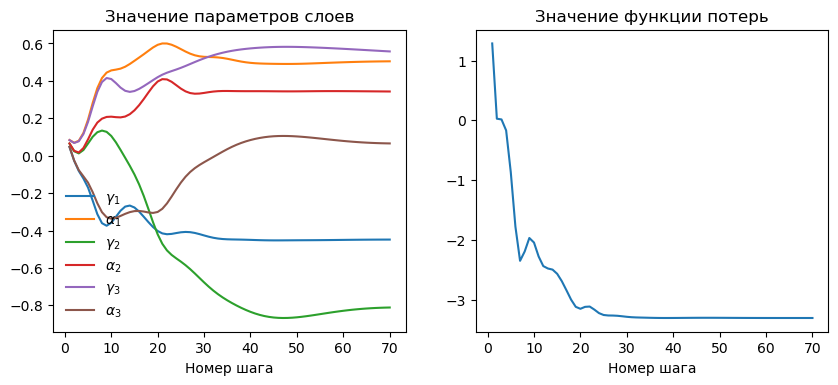

In [45]:
history_arr = np.array(history)
steps_list = np.arange(1, steps + 1)
fig, ax = plt.subplots(1,2, figsize=(10, 4))
for i in range(depth):
    ax[0].plot(steps_list, history_arr[:, 0, i], label=r'$\gamma_%d$' % (i + 1))
    ax[0].plot(steps_list, history_arr[:, 1, i], label=r'$\alpha_%d$' % (i + 1))
ax[0].set_xlabel('Номер шага')
ax[0].set_title('Значение параметров слоев')
ax[0].legend(frameon=False)


ax[1].plot(steps_list, cost_history)
ax[1].set_xlabel('Номер шага')
ax[1].set_title('Значение функции потерь')

plt.show()

Построим распределение вероятностей получить то илии иное базисное состояние в состоянии с максимальным ожидаемым значением гамильтониана $H_c(f)$.

In [46]:
def probability_circuit(dev):
    @qml.qnode(dev)
    def circuit(nparams):
        qaoa_circuit(nparams)
        return qml.probs(wires=wires)
    
    return circuit

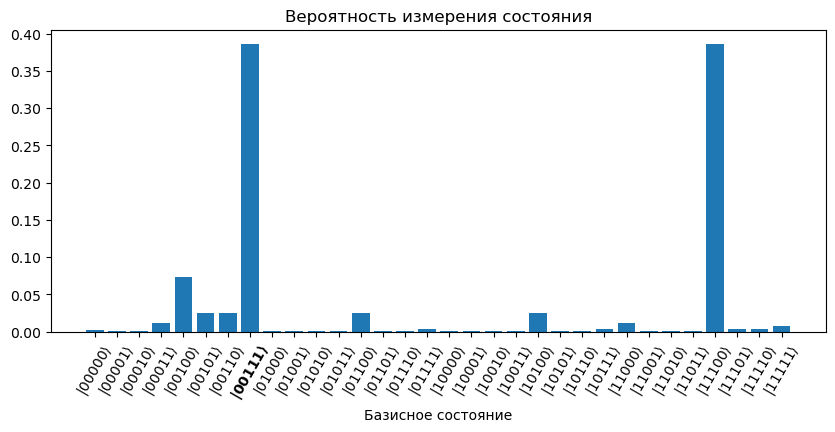

In [47]:
probs = probability_circuit(dev)(nparams)
pos = range(2 ** len(wires))
states = [f"$|{i:05b}\\rangle$" for i in pos]
states[np.argmax(probs)] = r"$\bf|{0:05b}\rangle$".format(np.argmax(probs))
fig, ax = plt.subplots(1,1, figsize=(10, 4))
plt.bar(pos, probs)
plt.xlabel('Базисное состояние')
plt.title('Вероятность измерения состояния')
plt.xticks(pos, states, rotation=60)
plt.show()

### Расчет на квантовом компьютере IBM

In [11]:
dev_ibmq = qml.device('qiskit.ibmq', wires=5, backend='ibmq_santiago', shots=2048)

#backend = provider.get_backend('ibmqx2')
#graph = nx.Graph(edges)

#nx.draw(graph, with_labels=True)
#plt.show()

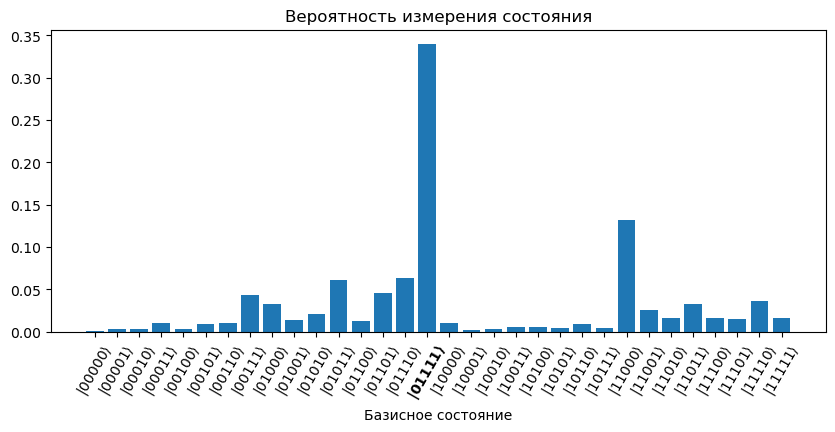

In [12]:
probs = probability_circuit(dev_ibmq)(nparams)
pos = range(2 ** len(wires))
states = [f"$|{i:05b}\\rangle$" for i in pos]
states[np.argmax(probs)] = r"$\bf|{0:05b}\rangle$".format(np.argmax(probs))
fig, ax = plt.subplots(1,1, figsize=(10, 4))
plt.bar(pos, probs)
plt.xlabel('Базисное состояние')
plt.title('Вероятность измерения состояния')
plt.xticks(pos, states, rotation=60)
plt.show()